In [1]:
import sympy as sp
import jax.numpy as np
import matplotlib.pyplot as plt

from util.interfaces import Config, EqInfo, Hyperparameters, VarInfo
from main import run

In [17]:
config = Config(
  eq = EqInfo(
    name = 'S',
    function = lambda s: s.d2Sdx2 - s.k ** 2 * s.S / (1 + s.S) - s.dSdt,
  ),
  vars = {
    'x': VarInfo(bounds=(0, 1), integrable=False),
    'k': VarInfo(bounds=(9.9, 10.1), integrable=False, symbol=r'\sigma'), # 9.9 ~ 10.1
    't': VarInfo(bounds=(0.001, 1), integrable=False),
    'S0': VarInfo(bounds=(0.01, 1), integrable=False, symbol=r'S_0')
  },
  conditions = [
    (1., lambda s: s.S.subs(s.t, 0)),
    (1., lambda s: s.S.subs(s.x, 1).subs(s.t, 0) - s.S0),
    (1., lambda s: s.S.subs(s.x, 1) - s.S0),
    (1., lambda s: s.dSdx.subs(s.x, 0)),
  ],
  preoperations = [
    lambda x, k, t, S0: 1,
    lambda x, k, t, S0: x,
    lambda x, k, t, S0: k,
    lambda x, k, t, S0: t,
    lambda x, k, t, S0: S0,
    lambda x, k, t, S0: x - k,
    lambda x, k, t, S0: 1 / sp.cosh(k),
  ],
  operations = [
    lambda z: 0,
    lambda z: 1,
    lambda z: z,
    lambda z: z**2,
    lambda z: z + 1,
    lambda z: 1 / z,
    lambda z: -z,
    lambda z: sp.cos(z),
    lambda z: sp.exp(z),
    lambda z: sp.cosh(z),
    lambda z: 1 / sp.cosh(z),
  ],
  hyperparameters = Hyperparameters(
    lr = 0.0001,
    penalty = 1,
    cellcount = 4,
  ),
  epochs = 128,
  batchsize = 64,
  verbosity = 1,
  seed = 2,
)

In [18]:
network, best, loss_histories = run(config)

22:19:19.414 [INFO] Constructed symbolic model
22:27:26.814 [INFO] Constructed loss equation
22:27:35.810 [INFO] Constructed JAXified model
22:27:43.622 [INFO] Epoch: 1, Loss: 36.2318191528
22:27:44.264 [INFO] Epoch: 10, Loss: 6.2648000717
22:27:44.943 [INFO] Epoch: 20, Loss: 5.8779506683
22:27:45.523 [INFO] Epoch: 30, Loss: 5.5964384079
22:27:46.610 [INFO] Epoch: 40, Loss: 5.3107199669
22:27:46.678 [INFO] Epoch: 50, Loss: 5.1351180077
22:27:47.268 [INFO] Epoch: 60, Loss: 4.9403343201
22:27:47.834 [INFO] Epoch: 70, Loss: 4.7507495880
22:27:48.415 [INFO] Epoch: 80, Loss: 4.5994577408
22:27:49.700 [INFO] Epoch: 90, Loss: 4.4783926010
22:27:49.598 [INFO] Epoch: 100, Loss: 4.3701891899
22:27:50.164 [INFO] Epoch: 110, Loss: 4.2895231247
22:27:50.682 [INFO] Epoch: 120, Loss: 4.2393894196
22:27:51.101 [INFO] Epoch: 128, Loss: 4.2102804184
22:27:51.101 [INFO] Pruning weights...
22:27:51.105 [INFO] Shed 0.02014484629034996 weight
22:27:51.292 [INFO] Constructed symbolic model
22:30:12.781 [INFO

Nothing more to prune!


$\displaystyle 6.45412073936313 \cdot 10^{-5} + \frac{0.33395254611969}{\cosh{\left(k \right)}}$

Best loss: 0.43429598212242126


In [19]:
best.loss

Array(0.43429598, dtype=float32)

In [20]:
y_prediction_best = best.model.subs(zip(best.alphas, best.W))
print(sp.latex(y_prediction_best))

6.45412073936313 \cdot 10^{-5} + \frac{0.33395254611969}{\cosh{\left(k \right)}}


In [21]:
from jax import vmap
x = network.symbols.x
k = network.symbols.k
t = network.symbols.t
S0 = network.symbols.S0
y_pred_fn = vmap(sp.lambdify([x, k, t, S0], y_prediction_best), (0, None, None, None))

In [22]:
y_pred_fn(np.array([0.5, 0.6]), np.array(0.1), np.array(0), np.array(1))

Array([0.33235422, 0.33235422], dtype=float32)

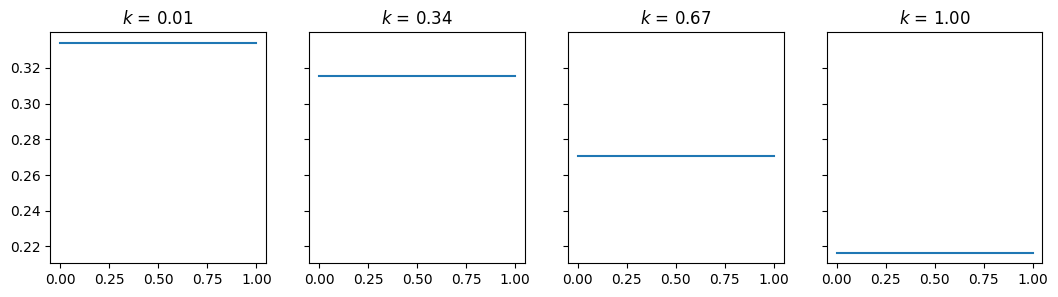

In [23]:
x_try = np.linspace(0, 1, 50)
k_tries = np.linspace(0.01, 1, 4, True)
t_try = 0
S0_try = 1
fig, axs = plt.subplots(1, len(k_tries), sharey=True)
fig.set_size_inches(len(k_tries)*3.2, 3)

for ax, k_try in zip(axs, k_tries):
  ax.set_title(f'$k$ = {k_try:.2f}')
  ax.plot(x_try, y_pred_fn(x_try, k_try, t_try, S0_try), label=f'prediction')
  # ax.legend()
plt.show()